In [22]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import chi2
import warnings
import itertools
import time

def main():
    """主执行函数，封装所有计算和分析步骤"""
    # ==============================================================================
    # Part 0: 环境设置
    # ==============================================================================
    warnings.filterwarnings('ignore', category=UserWarning)
    warnings.filterwarnings('ignore', category=FutureWarning)

    # ==============================================================================
    # Part 1: 数据加载与最终分析集准备
    # ==============================================================================
    print("--- [Part 1] 开始加载数据与准备 ---")

    # (1) 定义路径
    DATA_DIR = '../../Data/0' 
    RESULT_DIR = 'Result' 
    os.makedirs(RESULT_DIR, exist_ok=True)
    print(f"数据输入路径: 当前文件夹")
    print(f"结果输出路径: {RESULT_DIR}")

    # (2) 加载预处理好的数据
    try:
        processed_file_path = os.path.join(DATA_DIR, '男胎_预处理后数据.csv')
        male_df = pd.read_csv(processed_file_path)
        print(f"成功加载预处理后数据 {len(male_df)} 行。")
    except FileNotFoundError:
        print("\n" + "="*60)
        print(f"错误: 未在当前目录下找到 '男胎_预处理后数据.csv' 文件。")
        print("程序已终止。请确保您的数据文件和本脚本保存在同一个文件夹内。")
        print("="*60)
        return # 如果文件找不到，则终止函数

    # (3) 最终分析集清洗 (剔除Y浓度、孕周、BMI离群点)
    print("根据Y浓度、孕周、BMI的离群点标志进行数据筛选...")
    for col in ['Y染色体浓度', '孕周', '孕妇BMI']:
        Q1 = male_df[col].quantile(0.25)
        Q3 = male_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        male_df[f'{col}_is_outlier'] = ((male_df[col] < lower_bound) | (male_df[col] > upper_bound)).astype(int)

    final_filter = (male_df['Y染色体浓度_is_outlier'] == 0) & \
                   (male_df['孕周_is_outlier'] == 0) & \
                   (male_df['孕妇BMI_is_outlier'] == 0)

    model_data = male_df[final_filter].dropna(subset=['Y染色体浓度', '孕周', '孕妇BMI', '孕妇代码']).copy()
    print(f"筛选后最终分析集 {len(model_data)} 行。")

    if model_data.empty:
        print("\n错误：筛选后无剩余数据。")
        return

    # (4) 特征工程
    model_data['GW'] = model_data['孕周']
    model_data['BMI'] = model_data['孕妇BMI']

    # (5) 保存用于可视化的清洁数据
    model_data.to_csv(os.path.join(RESULT_DIR, 'final_model_data.csv'), index=False, encoding='utf-8-sig')
    print(f"用于可视化的清洁数据已保存至 Result/final_model_data.csv")


    # ==============================================================================
    # Part 2: 最优子集选择
    # ==============================================================================
    print("\n--- [Part 2] 开始执行最优子集选择 ---")
    start_time = time.time()

    # (1) 定义候选预测因子全集 (无年龄，最高三次)
    predictors = [
        'GW', 'I(GW**2)', 'I(GW**3)',
        'BMI', 'I(BMI**2)', 'I(BMI**3)',
        'GW:BMI', 'I(GW**2):BMI', 'GW:I(BMI**2)'
    ]
    print(f"候选预测因子全集 ({len(predictors)}个): {predictors}")

    # (2) "海选" - OLS最优子集搜索
    print("\n阶段一：OLS“海选”开始（此过程计算量大，请耐心等待）...")
    best_models_by_size = {}
    total_combinations = sum(len(list(itertools.combinations(predictors, k))) for k in range(1, len(predictors) + 1))
    print(f"将要测试 {total_combinations} 种固定效应组合...")
    tested_count = 0

    for k in range(1, len(predictors) + 1):
        best_bic_k = np.inf
        best_formula_k = None
        for combo in itertools.combinations(predictors, k):
            tested_count += 1
            formula = f"Y染色体浓度 ~ {' + '.join(combo)}"
            if tested_count % 50 == 0 or tested_count == 1:
                print(f"  ...已测试 {tested_count}/{total_combinations} 种组合...")
            try:
                ols_model = smf.ols(formula, data=model_data).fit()
                if ols_model.bic < best_bic_k:
                    best_bic_k = ols_model.bic
                    best_formula_k = formula
            except Exception:
                continue
        best_models_by_size[k] = {'formula': best_formula_k, 'bic': best_bic_k}
        print(f"完成 {k} 个变量组合的搜索, 最优公式: {best_formula_k} (OLS BIC: {best_bic_k:.2f})")

    print("\n阶段一：OLS“海选”完成！")

    # (3) "决赛" - LMM最终对决
    print("\n阶段二：LMM“决赛”开始...")
    final_candidates = [v['formula'] for k, v in best_models_by_size.items() if v['formula'] is not None]
    best_lmm_model = None; best_lmm_bic = np.inf; best_lmm_formula = None

    for i, formula in enumerate(final_candidates):
        print(f"  正在测试决赛模型 {i+1}/{len(final_candidates)}: {formula}")
        try:
            lmm_model = smf.mixedlm(formula, data=model_data, groups='孕妇代码', re_formula='~ GW').fit(reml=False, method='cg')
            print(f"    --> 拟合成功 (LMM BIC: {lmm_model.bic:.2f})")
            if lmm_model.bic < best_lmm_bic:
                best_lmm_bic = lmm_model.bic
                best_lmm_model = lmm_model
                best_lmm_formula = formula
                print(f"    *** 发现当前最优LMM模型！ ***")
        except Exception as e:
            print(f"    --> 拟合失败: {e}")
            continue

    m4_final = best_lmm_model
    end_time = time.time()
    print("\n" + "="*60); print("最优子集选择完成！"); print(f"总耗时: {end_time - start_time:.2f} 秒")
    print(f"最终胜出M4模型的BIC值为: {best_lmm_bic:.4f}"); print(f"最终胜出M4模型的公式为:\n{best_lmm_formula}"); print("="*60)

    # ==============================================================================
    # Part 3: 最终模型评估与输出
    # ==============================================================================
    print("\n--- [Part 3] 开始最终模型评估与输出 ---")
    if m4_final is None:
        print("错误：未能成功确定最终的M4模型，程序终止。"); return

    # (1) 保存M4固定效应表
    print("正在保存最优模型 M4 的详细结果...")
    fe_params = m4_final.fe_params; fe_index = fe_params.index
    conf_int_fe = m4_final.conf_int().loc[fe_index]
    pvalues_fe = m4_final.pvalues.loc[fe_index]
    tvalues_fe = m4_final.tvalues.loc[fe_index]
    fe_df = pd.DataFrame({
        '变量': fe_params.index, '系数': fe_params.values, '标准误': m4_final.bse_fe.loc[fe_index].values,
        'z值': tvalues_fe.values, 'p值': pvalues_fe.values,
        'CI_lower': conf_int_fe.iloc[:, 0].values, 'CI_upper': conf_int_fe.iloc[:, 1].values
    })
    fe_path = os.path.join(RESULT_DIR, '表格_最终模型M4_固定效应表.csv')
    fe_df.to_csv(fe_path, index=False, encoding='utf-8-sig', float_format='%.6e')
    print(f"M4固定效应表已保存至: {fe_path}")

    # (2) 保存M4方差成分表
    re_names = m4_final.cov_re.index.tolist()
    vc_table = pd.DataFrame({'方差成分': [f'随机斜率_方差({re_names[0]})', f'随机截距_方差({re_names[1]})', '残差_方差'], '估计值': [m4_final.cov_re.iloc[0, 0], m4_final.cov_re.iloc[1, 1], m4_final.scale]})
    vc_path = os.path.join(RESULT_DIR, '表格_最终模型M4_方差成分表.csv')
    vc_table.to_csv(vc_path, index=False, encoding='utf-8-sig', float_format='%.6e')
    print(f"M4方差成分表已保存至: {vc_path}")

    # (3) 保存M4的R²分解表
    var_fe = np.var(m4_final.fittedvalues); random_effects = m4_final.random_effects
    var_re_approx = np.var([np.dot(dr, er) for dr, er in zip(m4_final.model.exog_re, random_effects.values())]); var_resid = m4_final.scale
    r2_marginal = var_fe / (var_fe + var_re_approx + var_resid)
    r2_conditional = (var_fe + var_re_approx) / (var_fe + var_re_approx + var_resid)
    r2_table = pd.DataFrame({'指标': ['边际 R-squared', '条件 R-squared'], '值': [r2_marginal, r2_conditional]})
    r2_path = os.path.join(RESULT_DIR, '表格_最终模型M4_R2分解表.csv')
    r2_table.to_csv(r2_path, index=False, encoding='utf-8-sig', float_format='%.6e')
    print(f"M4 的 R-squared 分解结果已保存至: {r2_path}")

    # (4) 保存M4模型摘要
    summary_path = os.path.join(RESULT_DIR, '文本_最终模型M4_详细摘要.txt')
    with open(summary_path, 'w', encoding='utf-8') as f:
        f.write("="*40 + " M4_优化混合效应模型 " + "="*40 + "\n")
        f.write(str(m4_final.summary()) + "\n\n")
    print(f"M4模型详细摘要已保存至: {summary_path}")
    print("--- 所有分析与输出已全部完成！ ---")


# 在脚本的主级别调用main函数
if __name__ == "__main__":
    main()

--- [Part 1] 开始加载数据与准备 ---
数据输入路径: 当前文件夹
结果输出路径: Result
成功加载预处理后数据 998 行。
根据Y浓度、孕周、BMI的离群点标志进行数据筛选...
筛选后最终分析集 962 行。
用于可视化的清洁数据已保存至 Result/final_model_data.csv

--- [Part 2] 开始执行最优子集选择 ---
候选预测因子全集 (9个): ['GW', 'I(GW**2)', 'I(GW**3)', 'BMI', 'I(BMI**2)', 'I(BMI**3)', 'GW:BMI', 'I(GW**2):BMI', 'GW:I(BMI**2)']

阶段一：OLS“海选”开始（此过程计算量大，请耐心等待）...
将要测试 511 种固定效应组合...
  ...已测试 1/511 种组合...
完成 1 个变量组合的搜索, 最优公式: Y染色体浓度 ~ I(BMI**3) (OLS BIC: -3971.03)
完成 2 个变量组合的搜索, 最优公式: Y染色体浓度 ~ I(BMI**3) + GW:I(BMI**2) (OLS BIC: -3982.50)
  ...已测试 50/511 种组合...
  ...已测试 100/511 种组合...
完成 3 个变量组合的搜索, 最优公式: Y染色体浓度 ~ I(BMI**2) + I(BMI**3) + GW:I(BMI**2) (OLS BIC: -3981.83)
  ...已测试 150/511 种组合...
  ...已测试 200/511 种组合...
  ...已测试 250/511 种组合...
完成 4 个变量组合的搜索, 最优公式: Y染色体浓度 ~ GW + I(GW**2) + I(GW**3) + I(BMI**3) (OLS BIC: -3987.40)
  ...已测试 300/511 种组合...
  ...已测试 350/511 种组合...
完成 5 个变量组合的搜索, 最优公式: Y染色体浓度 ~ I(GW**2) + I(GW**3) + I(BMI**2) + GW:BMI + I(GW**2):BMI (OLS BIC: -3986.56)
  ...已测试 400/511 种组合...
  ...已测试

--- [Part 0] 环境准备中... ---
结果图片将保存至: Result
--- [Part 0] 环境、数据与模型准备就绪 ---
--- 正在生成 [图一：Y浓度离群点剔除可视化] ---


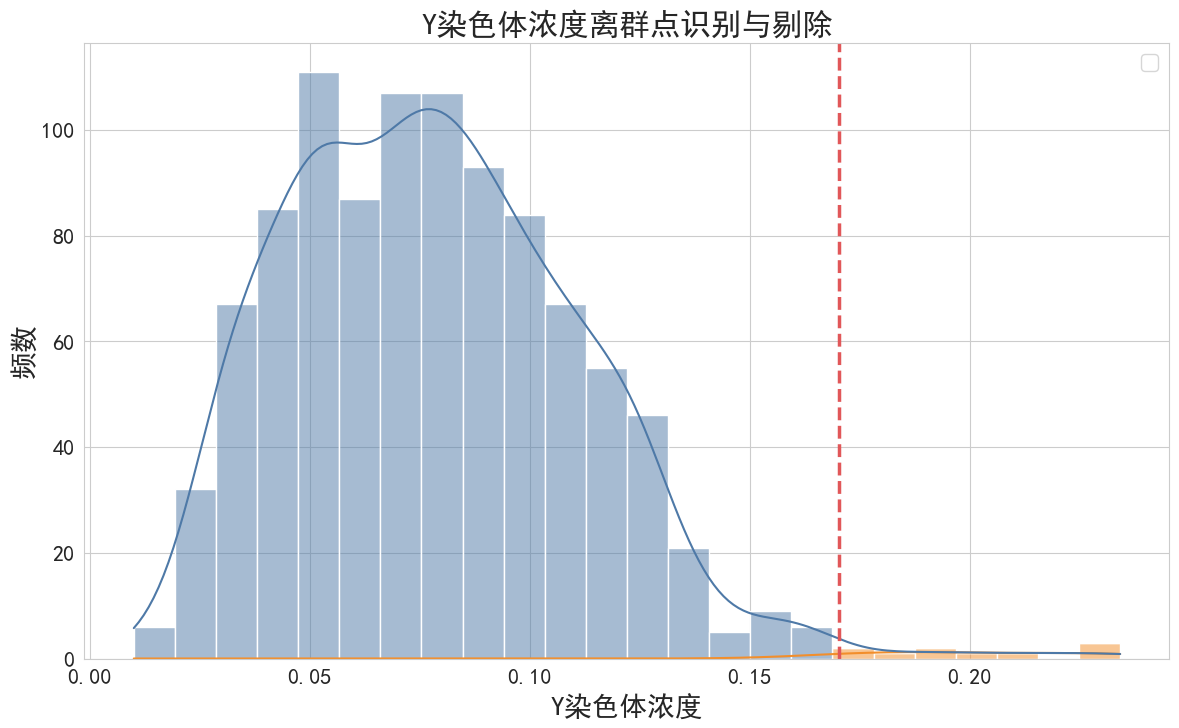

--- 正在生成 [图二、图三：核心变量散点图] ---


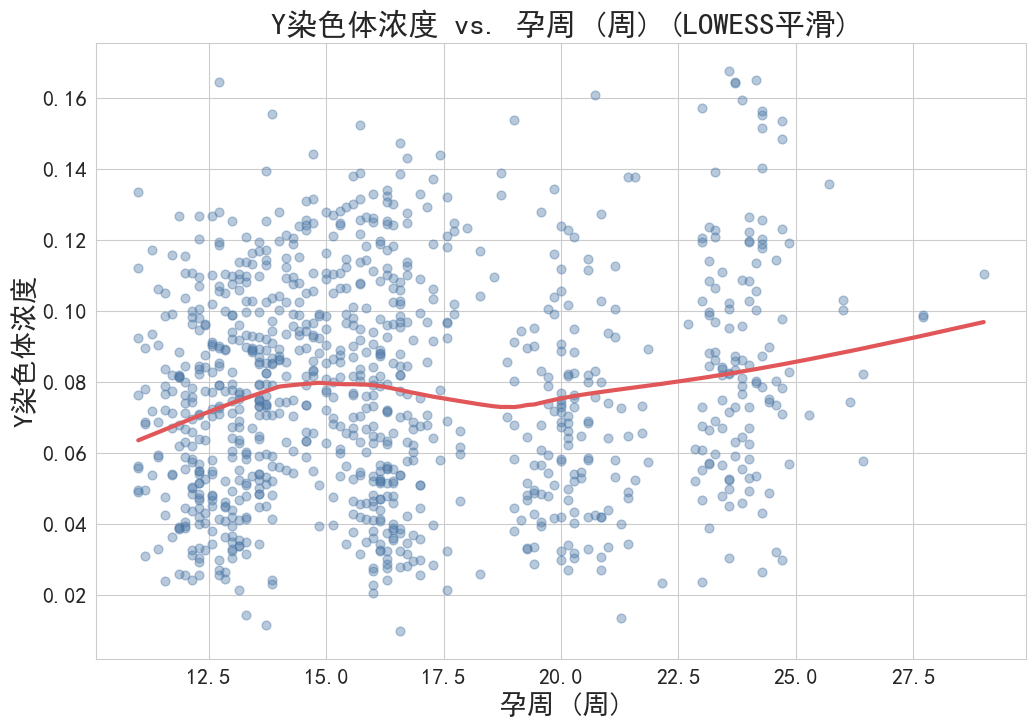

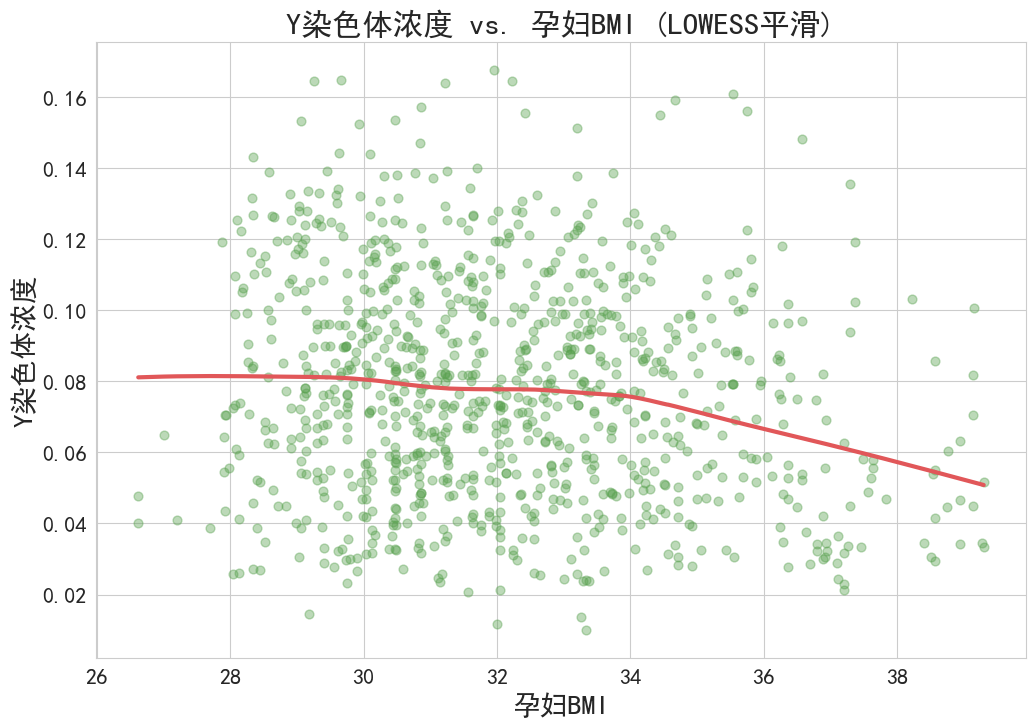

--- 正在生成 [图四：最终模型M4可视化] ---


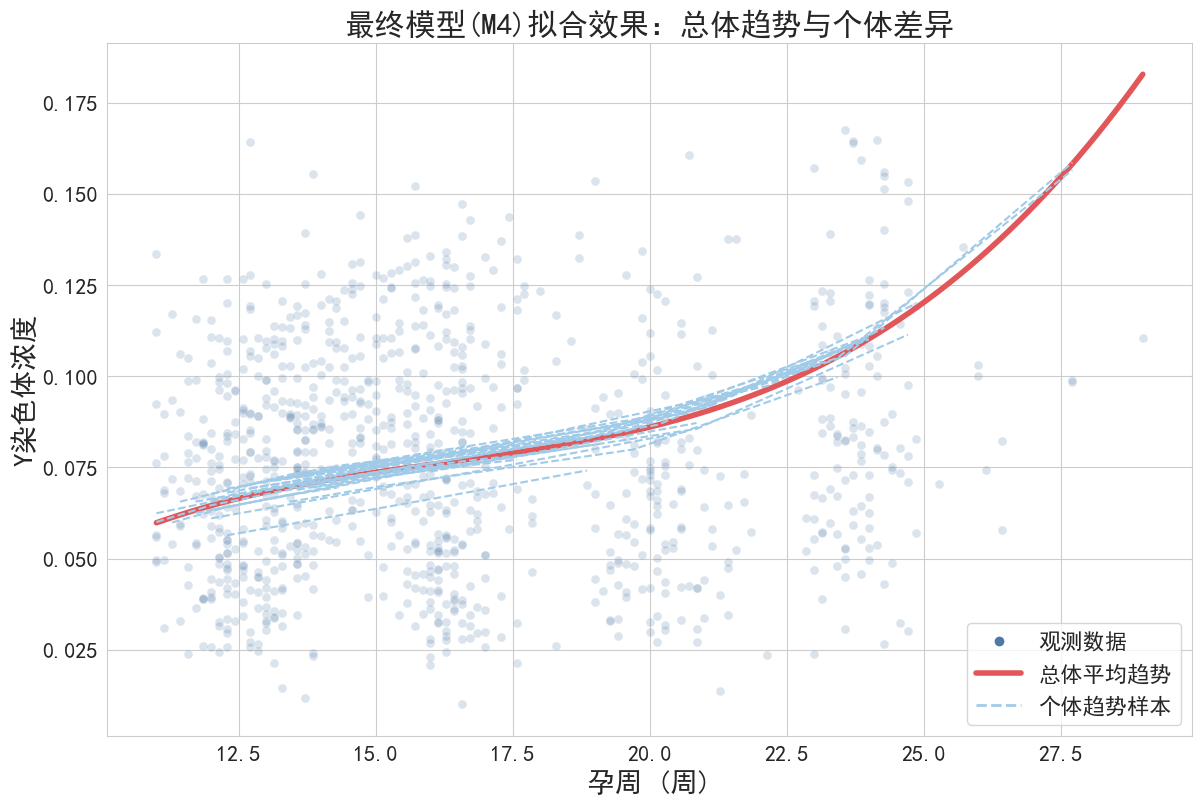


--- 所有可视化代码执行完毕 ---


In [23]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

def run_final_visualization():
    """
    根据最终要求，生成一套风格统一、美化后的高质量可视化图表。
    """
    # ==============================================================================
    # Part 0: 环境设置、数据加载与模型重现
    # ==============================================================================
    print("--- [Part 0] 环境准备中... ---")
    
    # --- 路径与美学风格定义 ---
    DATA_DIR = '../../Data/0'
    IMAGE_DIR = 'Result'
    
    os.makedirs(IMAGE_DIR, exist_ok=True)

    plt.rcParams['font.sans-serif'] = ['SimHei']
    plt.rcParams['axes.unicode_minus'] = False
    PALETTE = {
        "scatter_main": "#4E79A7", "scatter_alt1": "#59A14F",
        "line_fit": "#E15759", "outlier": "#F28E2B", 
        "individual_lines": "#A0CBE8"
    }
    sns.set_style("whitegrid", {"font.sans-serif": ['SimHei', 'Arial']})
    print(f"结果图片将保存至: {IMAGE_DIR}")

    # --- 数据加载 ---
    try:
        processed_file_path = os.path.join(DATA_DIR, '男胎_预处理后数据.csv')
        male_df = pd.read_csv(processed_file_path)
    except FileNotFoundError:
        print(f"\n错误: 未在 '{DATA_DIR}' 目录下找到 '男胎_预处理后数据.csv' 文件。")
        return

    # --- 数据清洗与最终分析集确定 ---
    # 仅根据Y染色体浓度定义离群点用于绘图
    col = 'Y染色体浓度'
    Q1 = male_df[col].quantile(0.25)
    Q3 = male_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound_y = Q1 - 1.5 * IQR
    upper_bound_y = Q3 + 1.5 * IQR
    male_df['is_outlier_y'] = (male_df[col] < lower_bound_y) | (male_df[col] > upper_bound_y)
    
    # 确定用于建模的最终清洁数据集 (规则不变，剔除三者中任意离群点)
    for col_filter in ['孕周', '孕妇BMI']:
        Q1_f = male_df[col_filter].quantile(0.25); Q3_f = male_df[col_filter].quantile(0.75)
        IQR_f = Q3_f - Q1_f
        lower_f = Q1_f - 1.5 * IQR_f; upper_f = Q3_f + 1.5 * IQR_f
        male_df[f'{col_filter}_is_outlier'] = (male_df[col_filter] < lower_f) | (male_df[col_filter] > upper_f)
    
    final_clean_mask = ~((male_df['is_outlier_y']) | (male_df['孕周_is_outlier']) | (male_df['孕妇BMI_is_outlier']))
    model_data = male_df[final_clean_mask].dropna(subset=['Y染色体浓度', '孕周', '孕妇BMI', '孕妇代码']).copy()
    model_data.rename(columns={'孕周': 'GW', '孕妇BMI': 'BMI'}, inplace=True)
    
    # --- 模型重现 ---
    final_formula = 'Y染色体浓度 ~ GW + I(GW**2) + I(GW**3) + I(BMI**3)'
    m4_final = smf.mixedlm(final_formula, data=model_data, groups='孕妇代码', re_formula='~ GW').fit(reml=False, method='cg')
    print("--- [Part 0] 环境、数据与模型准备就绪 ---")
    
    # ==============================================================================
    # 图一：Y染色体浓度离群点剔除可视化 (按要求更新)
    # ==============================================================================
    print("--- 正在生成 [图一：Y浓度离群点剔除可视化] ---")
    plt.figure(figsize=(14, 8))
    
    # 注意：这里的hue是根据Y浓度本身是否为离群点
    sns.histplot(data=male_df, x='Y染色体浓度', hue='is_outlier_y', 
                 palette={False: PALETTE['scatter_main'], True: PALETTE['outlier']}, 
                 kde=True, multiple="stack")
    
    plt.axvline(x=upper_bound_y, color=PALETTE['line_fit'], linestyle='--', linewidth=2.5)
    
    # 自定义图例
    handles, labels = plt.gca().get_legend_handles_labels()
    n_kept = male_df['is_outlier_y'].value_counts()[False]
    n_outlier = male_df['is_outlier_y'].value_counts()[True]
    plt.legend(handles=handles, labels=[f'保留的数据 (n={n_kept})', f'剔除的数据 (n={n_outlier})'], fontsize=16)
    
    plt.xlabel('Y染色体浓度', fontsize=20); plt.ylabel('频数', fontsize=20)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.title('Y染色体浓度离群点识别与剔除', fontsize=22)
    
    plt.savefig(os.path.join(IMAGE_DIR, '图1_Y浓度离群点剔除可视化.png'), dpi=300, bbox_inches='tight')
    plt.show()

    # ==============================================================================
    # 图二、图三：核心变量散点图 (EDA)
    # ==============================================================================
    print("--- 正在生成 [图二、图三：核心变量散点图] ---")
    scatter_vars = {'GW': PALETTE['scatter_main'], 'BMI': PALETTE['scatter_alt1']}
    chart_counter = 2
    for var, color in scatter_vars.items():
        plt.figure(figsize=(12, 8))
        sns.regplot(data=model_data, x=var, y='Y染色体浓度', 
                    scatter_kws={'alpha': 0.4, 'color': color, 's': 40}, 
                    line_kws={'color': PALETTE['line_fit'], 'linewidth': 3},
                    lowess=True)
        
        var_label = '孕周 (周)' if var == 'GW' else '孕妇BMI'
        plt.xlabel(var_label, fontsize=20); plt.ylabel('Y染色体浓度', fontsize=20)
        plt.xticks(fontsize=16); plt.yticks(fontsize=16)
        plt.title(f'Y染色体浓度 vs. {var_label} (LOWESS平滑)', fontsize=22)
        
        plt.savefig(os.path.join(IMAGE_DIR, f'图{chart_counter}_Y浓度_vs_{var}_散点图.png'), dpi=300, bbox_inches='tight')
        plt.show()
        chart_counter += 1
        
    # ==============================================================================
    # 图四：最终模型M4的可视化图 (核心结果)
    # ==============================================================================
    print("--- 正在生成 [图四：最终模型M4可视化] ---")
    plt.figure(figsize=(14, 9))

    # 绘制背景观测数据点
    sns.scatterplot(data=model_data, x='GW', y='Y染色体浓度', color=PALETTE['scatter_main'], alpha=0.2, s=40, label='观测数据')

    # 计算并绘制总体平均趋势 (固定效应)
    gw_range = np.linspace(model_data['GW'].min(), model_data['GW'].max(), 200)
    plot_data = pd.DataFrame({
        'GW': gw_range,
        'BMI': model_data['BMI'].mean()
    })
    y_pop_trend = m4_final.predict(plot_data)
    plt.plot(gw_range, y_pop_trend, color=PALETTE['line_fit'], linewidth=4, linestyle='-', label='总体平均趋势 (固定效应)')

    # 随机抽样并绘制个体趋势 (固定+随机效应)
    np.random.seed(42) # for reproducibility
    random_subjects = np.random.choice(model_data['孕妇代码'].unique(), 30, replace=False)
    for i, subject in enumerate(random_subjects):
        subject_data = model_data[model_data['孕妇代码'] == subject].sort_values('GW')
        y_ind_trend = m4_final.predict(subject_data)
        label = '个体趋势样本' if i == 0 else None
        plt.plot(subject_data['GW'], y_ind_trend, color=PALETTE['individual_lines'], linewidth=1.5, linestyle='--')

    # 手动添加个体趋势的图例
    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=PALETTE['scatter_main'], marker='o', linestyle='None'),
                    Line2D([0], [0], color=PALETTE['line_fit'], lw=4),
                    Line2D([0], [0], color=PALETTE['individual_lines'], lw=2, ls='--')]
    
    plt.legend(custom_lines, ['观测数据', '总体平均趋势', '个体趋势样本'], fontsize=16)
    plt.xlabel('孕周 (周)', fontsize=20); plt.ylabel('Y染色体浓度', fontsize=20)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.title('最终模型(M4)拟合效果：总体趋势与个体差异', fontsize=22)
    
    plt.savefig(os.path.join(IMAGE_DIR, '图4_最终模型M4_可视化.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n--- 所有可视化代码执行完毕 ---")


if __name__ == "__main__":
    run_final_visualization()